<a href="https://colab.research.google.com/github/vksyr/IST718/blob/master/Async9.x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd  # data frame operations
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt  # 2D plotting
import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING
import math

import pandas as pd

from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

import plotly as py
import plotly.graph_objects as go

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [0]:
# Dataset was converted to CSV with this script: 
# https://pjreddie.com/projects/mnist-in-csv/
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

convert("/content/drive/My Drive/IST718/HW3/train-images-idx3-ubyte", "/content/drive/My Drive/IST718/HW3/train-labels-idx1-ubyte",
        "/content/drive/My Drive/IST718/HW3/mnist_train.csv", 60000)
convert("/content/drive/My Drive/IST718/HW3/t10k-images-idx3-ubyte", "/content/drive/My Drive/IST718/HW3/t10k-labels-idx1-ubyte",
        "/content/drive/My Drive/IST718/HW3/mnist_test.csv", 10000)

In [27]:
# create pandas df
cols = np.array(['label'])
for i in range(1,785):
  cols = np.append(cols, ['pixel' + str(i)])

train_images = pd.read_csv('/content/drive/My Drive/IST718/HW3/mnist_train.csv', 
                          header=None, names=cols)
test_images = pd.read_csv('/content/drive/My Drive/IST718/HW3/mnist_test.csv', 
                          header=None, names=cols)


# Train/Validation Split
idx = np.arange(60000)
np.random.shuffle(idx)
print(idx[:5])
val_images = train_images.iloc[idx[:10000]]
train_images = train_images.iloc[idx[10000:]]
print(train_images.shape, val_images.shape)


[45166 50164 11145 59960 22411]
(50000, 785) (10000, 785)


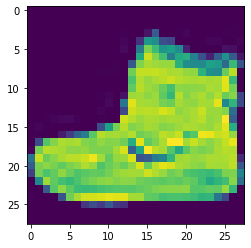

Label: 9


In [3]:
# plotting an image
import matplotlib.pyplot as plt
image = np.asarray(train_images.loc[0][1:]).squeeze()
plt.imshow(image.reshape(28, 28, 1).squeeze())
plt.show()

print('Label: ' + str(train_images.loc[0][0]))

In [0]:
# how many categories?
from collections import Counter
Counter(train_images.iloc[:,0])

Tensorflow

In [8]:
%tensorflow_version 1.x  #gpu
import tensorflow as tf
tf.compat.v1.disable_eager_execution() 
# needs to be disabled for placeholder
# enabled for iteration

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x  #gpu`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


TCN

In [0]:
class CausalConv1D(tf.layers.Conv1D):
    def __init__(self, filters,
               kernel_size,
               strides=1,
               dilation_rate=1,
               activation=None,
               use_bias=True,
               kernel_initializer=None,
               bias_initializer=tf.zeros_initializer(),
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               trainable=True,
               name=None,
               **kwargs):
        super(CausalConv1D, self).__init__(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding='valid',
            data_format='channels_last',
            dilation_rate=dilation_rate,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            trainable=trainable,
            name=name, **kwargs
        )
       
    def call(self, inputs):
        padding = (self.kernel_size[0] - 1) * self.dilation_rate[0]
        inputs = tf.pad(inputs, tf.constant([(0, 0,), (1, 0), (0, 0)]) * padding)
        return super(CausalConv1D, self).call(inputs)

In [0]:
class TemporalBlock(tf.layers.Layer):
    def __init__(self, n_outputs, kernel_size, strides, dilation_rate, dropout=0.2, 
                 trainable=True, name=None, dtype=None, batch_size=32,
                 activity_regularizer=None, **kwargs):
        super(TemporalBlock, self).__init__(
            trainable=trainable, dtype=dtype,
            activity_regularizer=activity_regularizer,
            name=name, **kwargs
        )        
        self.dropout = dropout
        self.batch_size = tf.cast(batch_size, tf.int32)
        self.n_outputs = n_outputs
        self.conv1 = CausalConv1D(
            n_outputs, kernel_size, strides=strides, 
            dilation_rate=dilation_rate, activation=tf.nn.relu, 
            name="conv1")
        self.conv2 = CausalConv1D(
            n_outputs, kernel_size, strides=strides, 
            dilation_rate=dilation_rate, activation=tf.nn.relu, 
            name="conv2")
        self.down_sample = None

    
    def build(self, input_shape):
        channel_dim = 2
        self.dropout1 = tf.layers.Dropout(self.dropout, [self.batch_size, tf.constant(1), tf.constant(self.n_outputs)])
        self.dropout2 = tf.layers.Dropout(self.dropout, [self.batch_size, tf.constant(1), tf.constant(self.n_outputs)])
        if input_shape[channel_dim] != self.n_outputs:
            # self.down_sample = tf.layers.Conv1D(
            #     self.n_outputs, kernel_size=1, 
            #     activation=None, data_format="channels_last", padding="valid")
            self.down_sample = tf.layers.Dense(self.n_outputs, activation=None)
        self.built = True
    
    def call(self, inputs, training=True):
        x = self.conv1(inputs)
        x = tf.contrib.layers.layer_norm(x)
        x = self.dropout1(x, training=training)
        x = self.conv2(x)
        x = tf.contrib.layers.layer_norm(x)
        x = self.dropout2(x, training=training)
        if self.down_sample is not None:
            inputs = self.down_sample(inputs)
        return tf.nn.relu(x + inputs)

In [0]:
class TemporalConvNet(tf.layers.Layer):
    def __init__(self, num_channels, kernel_size=2, dropout=0.2,
                 trainable=True, name=None, dtype=None, batch_size=32,
                 activity_regularizer=None, **kwargs):
        super(TemporalConvNet, self).__init__(
            trainable=trainable, dtype=dtype,
            activity_regularizer=activity_regularizer,
            name=name, **kwargs
        )
        self.layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            out_channels = num_channels[i]
            self.layers.append(
                TemporalBlock(
                    out_channels, kernel_size, strides=1, 
                    dilation_rate=dilation_size, batch_size=batch_size,
                    dropout=dropout, name="tblock_{}".format(i))
            )
    
    def call(self, inputs, training=True):
        outputs = inputs
        for layer in self.layers:
            outputs = layer(outputs, training=training)
        return outputs

In [0]:
'''
image_size = 28
labels_size = 10
learning_rate = 0.05
steps_number = 1000
batch_size = 100

# Define placeholders
training_data = tf.placeholder(tf.float32, [None, image_size*image_size])
labels = tf.placeholder(tf.float32, [None, labels_size])

# Variables to be tuned
W = tf.Variable(tf.truncated_normal([image_size*image_size, labels_size], stddev=0.1))
b = tf.Variable(tf.constant(0.1, shape=[labels_size]))

# Build the network (only output layer)
output = tf.matmul(training_data, W) + b

# Define the loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=output))

# Training step
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

# Accuracy calculation
correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
'''

Build the Model

In [28]:
# Training Parameters
learning_rate = 0.001
batch_size = 32
display_step = 500
print("Total batches per epoch:", np.ceil(train_images.shape[0] / batch_size))
training_steps = 10000

# Network Parameters
num_input = 1 # MNIST data input (img shape: 28*28)
timesteps = 28 * 28 # timesteps
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.05
kernel_size = 8
levels = 6
nhid = 24 # hidden layer num of features

Total batches per epoch: 1563.0


In [0]:
def process_batch(batch_x, batch_y):
    return tf.expand_dims(batch_x, -1), tf.one_hot(batch_y, num_classes)

In [30]:
tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
    tf.set_random_seed(10)
    
    with tf.variable_scope("datasets"):
        training_batch_size = tf.placeholder(tf.int64) # tf.constant(32, dtype="int64")
        inference_batch_size = tf.placeholder(tf.int64) # tf.constant(500, dtype="int64")
        is_training = tf.placeholder("bool")

        fminst_ds_train = tf.data.Dataset.from_tensor_slices(
            (train_images.iloc[:, 1:].astype("float32") / 255, train_images.iloc[:, 0].astype("int32"))
        ).shuffle(50000, reshuffle_each_iteration=True).repeat().batch(training_batch_size).map(process_batch)
        fminst_ds_val = tf.data.Dataset.from_tensor_slices(
            (val_images.iloc[:, 1:].astype("float32") / 255, val_images.iloc[:, 0].astype("int32"))
        ).repeat().batch(inference_batch_size).map(process_batch)
        fminst_ds_test = tf.data.Dataset.from_tensor_slices((
            test_images.iloc[:, 1:].astype("float32") / 255, test_images.iloc[:, 0].astype("int32"))
        ).repeat().batch(inference_batch_size).map(process_batch)

        handle = tf.placeholder(tf.string, shape=[])
        iterator = tf.data.Iterator.from_string_handle(
            handle, fminst_ds_train.output_types, fminst_ds_train.output_shapes)

        train_iterator = fminst_ds_train.make_initializable_iterator()
        val_iterator = fminst_ds_val.make_initializable_iterator()
        test_iterator = fminst_ds_test.make_initializable_iterator() 
    
    X_0, Y = iterator.get_next()
    X = tf.reshape(X_0, (-1, timesteps, num_input))

    # Define weights
    logits = tf.layers.dense(
        TemporalConvNet(
            [nhid] * levels, kernel_size, dropout, 
            batch_size=tf.shape(X)[0])(
            X, training=is_training)[:, -1, :],
        num_classes, activation=None, 
        kernel_initializer=tf.orthogonal_initializer()
    )
    prediction = tf.nn.softmax(logits)
   
    with tf.name_scope("loss"):
        # Define loss and optimizer
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
            logits=logits, labels=Y))
        ema_loss = tf.get_variable("ema_loss", shape=[], dtype=tf.float32, trainable=False, initializer=tf.constant_initializer(2.5))
        ema_update = ema_loss.assign(ema_loss * 0.99 + loss * 0.01)
    tf.summary.scalar('Loss', ema_loss)
    
    with tf.variable_scope("optimizer"):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        with tf.control_dependencies([ema_update]):
            train_op = optimizer.minimize(loss)

    with tf.variable_scope("inference"):
        # Evaluate model (with test logits, for dropout to be disabled)
        correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
            
    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    merged_summary_op = tf.summary.merge_all()
    print("All parameters:", np.sum([np.product([xi.value for xi in x.get_shape()]) for x in tf.global_variables()]))
    print("Trainable parameters:", np.sum([np.product([xi.value for xi in x.get_shape()]) for x in tf.trainable_variables()]))

All parameters: 156129.0
Trainable parameters: 52042


Training and Evaluating

In [0]:
# Start training
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
best_val_acc = 0.8

train_writer = tf.summary.FileWriter("logs/fminst_tcn/%s/train" % datetime.now().strftime("%Y%m%d_%H%M"), graph)
val_writer = tf.summary.FileWriter("logs/fminst_tcn/%s/val" % datetime.now().strftime("%Y%m%d_%H%M"))

with tf.Session(graph=graph, config=config) as sess:
    # Run the initializer    
    sess.run(init) 
    sess.run([train_iterator.initializer, val_iterator.initializer, test_iterator.initializer],
             feed_dict={training_batch_size: batch_size, inference_batch_size: 500})
    train_handle, val_handle, test_handle = sess.run(
        [train_iterator.string_handle(), val_iterator.string_handle(), test_iterator.string_handle()])
    for step in range(1, training_steps+1):
        sess.run([train_op], feed_dict={handle: train_handle, is_training: True})
        
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss_local, acc, summary = sess.run(
                [loss, accuracy, merged_summary_op], 
                feed_dict={handle: train_handle, is_training: False})
            train_writer.add_summary(summary, global_step=step)
            train_writer.flush()            
            val_acc, val_loss = [], []
            for _ in range(20):
                tmp = sess.run(
                    [accuracy, loss], 
                    feed_dict={handle: val_handle, is_training: False})
                val_acc.append(tmp[0])
                val_loss.append(tmp[1])
            summary = tf.Summary()
            val_loss = np.mean(val_loss)            
            val_acc = np.mean(val_acc)            
            summary.value.add(tag='Loss', simple_value=val_loss)
            val_writer.add_summary(summary, global_step=step)
            val_writer.flush() 
            print("Step " + str(step) + ", Train Batch Loss= " + \
                  "{:.4f}".format(loss_local) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc) + ", Val Accuracy= " + \
                  "{:.3f}".format(val_acc))
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                save_path = saver.save(sess, "/tmp/model.ckpt")
                print("Model saved in path: %s" % save_path)  
    test_acc = []
    for _ in range(20):
        test_acc.append(sess.run(accuracy, feed_dict={handle: test_handle, is_training: False}))
    test_acc = np.mean(test_acc)
    print("Test Accuracy= {:.3f}".format(test_acc))                
    print("Optimization Finished!")
    
train_writer.close()
val_writer.close()

Step 1, Train Batch Loss= 3.5564, Training Accuracy= 0.000, Val Accuracy= 0.084
Step 500, Train Batch Loss= 0.3704, Training Accuracy= 0.844, Val Accuracy= 0.780


TF model was produced using two convolution layers

In [0]:
# WEIGHT INITIALIZATION
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

# CREATE CONVOLUTION AND POOLING LAYERS
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# FIRST CONVOLUTION LAYER
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(x, [-1, 28, 28, 1]) # BASE IMAGE SIZE OF 28 * 28

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)  # RESULTING IMAGE SIZE IS 14 * 14

# SECOND CONOLUTION LAYER 
# MORE THAN ONE LAYER?  DEEP LEARNING
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#FULLY CONNECTED LAYER - BEFORE OUTPUT
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)  # ADD THE RECTIFIED LINEAR UNIT

# DROP LAYER - REDUCE OVERFITTING
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# LAST LAYER - OUTPUT
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# RUN THE MODEL
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(10000):
    batch = mnist.train.next_batch(50)
    if i % 100 == 0:
      train_accuracy = accuracy.eval(feed_dict={
          x: batch[0], y_: batch[1], keep_prob: 1.0})
      print('step %d, training accuracy %g' % (i, train_accuracy))
      print(batch[1])
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

  print('test accuracy %g' % accuracy.eval(feed_dict={
      x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
  
  #43s on gpu, 0.9908 acc

Keras

In [0]:
# load train and test dataset
# functions from https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = fashion_mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(211)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		pyplot.subplot(212)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['acc'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_acc'], color='orange', label='test')
	pyplot.show()

def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# append scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

> 91.583
> 90.875
> 91.558
> 90.892
> 90.833


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

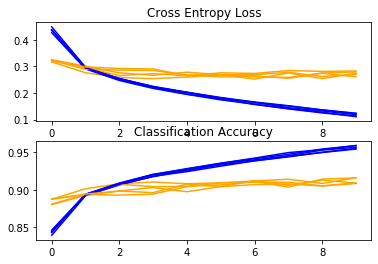

Accuracy: mean=91.148 std=0.346, n=5


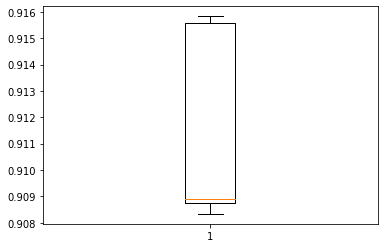

In [0]:
# run
# load dataset
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
# evaluate model
scores, histories = evaluate_model(trainX, trainY)
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)

# time: 1445s
# 91.148 std=0.346, n=5

In [0]:
# add padded convolutions and rerun
# time: 1503s
# mean acc: 91.07

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# load dataset
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
# evaluate model
scores, histories = evaluate_model(trainX, trainY)
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)

4423680/4422102 [==============================] - 1s 0us/step




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







> 90.667


KeyboardInterrupt: ignored

> 90.983
> 91.658
> 90.875
> 91.950
> 91.825


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future ver

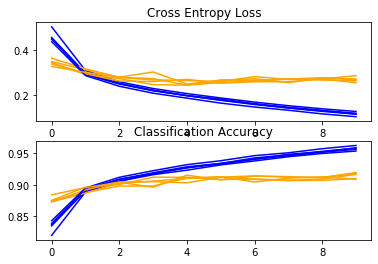

Accuracy: mean=91.458 std=0.443, n=5


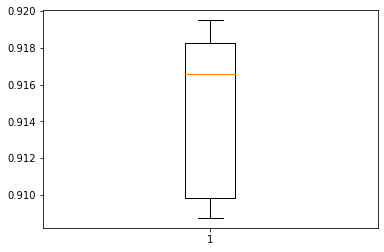

In [0]:
# add filters and rerun
def define_model():
	model = Sequential()
	model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# load dataset
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
# evaluate model
scores, histories = evaluate_model(trainX, trainY)
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)

# 2397s cpu=none, 318s cpu=gpu
# mean acc: 91.175

In [0]:

#Confution Matrix and Classification Report


In [0]:
# confusion matrix
import seaborn as sn

model = define_model()
trainX, testX = prep_pixels(trainX, testX)
y_pred = model.predict(testX)



df = pd.DataFrame(data={'y_Actual':np.argmax(testY, axis=1), 'y_Predicted':np.argmax(y_pred, axis=1)} )
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)